In [1]:
%matplotlib inline

In [2]:
import time
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split, KFold, cross_val_predict
from sklearn.base import clone
from sklearn.metrics import log_loss
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.grid_search import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin, BaseEstimator
import holidays
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from scipy.stats import expon as sp_expon
import matplotlib.pyplot as plt

# Turns off annoying warnings. If there are ever serious data
# errors, trying removing this line.
pd.options.mode.chained_assignment = None

In [3]:
class BasicFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, date_features=True, DayOfWeek_features=True, 
                 PdDistrict_features=True, Address_features=True, 
                 Interaction_feature=True, Holiday_features=True):
        """
        Add more features to the dataset. All of are stateless transforms and can be performed outside
        of a CV loop.
        """
        self.date_features = date_features
        self.DayOfWeek_features = DayOfWeek_features
        self.PdDistrict_features = PdDistrict_features
        self.Address_features = Address_features
        self.Interaction_feature = Interaction_feature
        self.Holiday_features = Holiday_features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X_df, y=None):
        # Features from dates
        X = X_df.copy()
        
        if self.date_features:
            X['Year'] = X.Dates.apply(lambda x: int(x[:4])) # Hypothesis: The distribution of crimes changed over time
            X['Month'] = X.Dates.apply(lambda x: int(x[5:7])) # H: Certain crimes occur during some months more than others
            X['Hour'] = X.Dates.apply(lambda x: int(x[11:13])) # H: Certain crimes occur at day, others at night
            X['Minute'] = X.Dates.apply(lambda x: int(x[14:16])) # H: Certain crimes are rounded to the nearest hour
            # Idea: Is holiday feature. H: Holidays --> Tourists --> Different types of crimes

        # Features from DayOfWeek
        if self.DayOfWeek_features:
            X['DayOfWeekNum'] = X["DayOfWeek"].map({"Tuesday":0, "Wednesday":1, 
                                                 "Thursday":2, "Friday":3, 
                                                 "Saturday":4, "Sunday":5, 
                                                 "Monday":6}) # H: Different days have different crime distributions
            X['IsWeekend'] = X["DayOfWeekNum"].apply(lambda x: 1*((x == 4) | (x == 5))) # H: Weekends are special

        # Features from PdDistrict
        if self.PdDistrict_features:
            X['PdDistrictNum'] = LabelEncoder().fit_transform(X.PdDistrict) # H: Different districts have different crimes

        # Features from Address
        if self.Address_features:
            X['Intersection'] = X.Address.apply(lambda x: 1*("/" in x)) # H: Intersections have unique crimes
        
        if self.Interaction_feature:
            X["Interaction"] = ((X.X-X.X.mean())/X.X.std())*((X.Y-X.Y.mean())/X.Y.std())
            
        if self.Holiday_features:
            us_holidays = holidays.UnitedStates()
            date = X.Dates.apply(lambda x: str(x[:10])) # yyyy-mm-dd
            holiday = date.apply(lambda x: x in us_holidays) #False/True
            X['Holiday'] = LabelEncoder().fit_transform(holiday) #Recode to numbers
        return X
    

class DuplicateCrimeCounts(BaseEstimator, TransformerMixin):
    """
    For each crime, count the number of other crimes that occurred at the exact time and location
    """
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        result = X.groupby(["Dates", "X", "Y"]).size()
        result = result.reset_index(name="crime_count")
        X = X.merge(result, how="left", on=["Dates", "X", "Y"])
        return X


class JustNumerics(BaseEstimator, TransformerMixin):
    """
    Drops all columns that are objects
    """
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.numeric_columns = X.dtypes[X.dtypes != "object"].index
        return self
    
    def transform(self, X, y=None):
        return X[self.numeric_columns]


class PCATransform(BaseEstimator, TransformerMixin):
    """
    PCA with an argument that allows the user to skip the transform 
    altogether.
    """
    def __init__(self, n_components=.1, skip=False, whiten=False, standard_scalar=True):
        self.n_components = n_components
        self.skip = skip
        self.whiten = whiten
        self.standard_scalar = standard_scalar
        
    def fit(self, X, y=None):
        if not self.skip:
            if self.standard_scalar:
                self.std_scalar = StandardScaler().fit(X)
                X = self.std_scalar.transform(X)
            self.pca = PCA(n_components=self.n_components, whiten=self.whiten).fit(X)
        return self
    
    def transform(self, X, y=None):
        if not self.skip:
            if self.standard_scalar:
                X = self.std_scalar.transform(X)
            return self.pca.transform(X)
        return X
    
class ModelBasedFeatures(BaseEstimator, TransformerMixin):
    """
    Adds a feature to the dataset based on the output of a model.
    
    Should include in FeatureUnion.
    """
    def __init__(self, model, feature_name, skip=False, train_cv=None):
        self.model = model
        self.feature_name = feature_name
        self.skip = skip
        self.train_cv = train_cv
    
    def _get_random_item(self, items):
        # Currently only handles scipy distributions
        return items.rvs()
    
    def fit(self, X, y=None, *args, **kwargs):
        # Purpose of skip is to skip the estimator
        if self.skip:
            return self
        
        # Hash train data. If test data equals train data, 
        # use cv predictions.
        if isinstance(X, pd.DataFrame):
            self.hashed_value = hash(X.values.data.tobytes())
        elif isinstance(X, np.ndarray):
            self.hashed_value = hash(X.data.tobytes())
        else:
            print("Can't hash data")
            
        # Get specific model param combo for this iteration
        self.model_params = {key: self._get_random_item(kwargs[key]) for key in kwargs}
        
        # Set params of model to these parameters
        self.model.set_params(**self.model_params)
        
        # Fit model
        self.model.fit(X, y)
        
        # Save y values
        self.y = y
        
        return self
    
    def transform(self, X):
        # Purpose of skip is to skip the estimator
        if self.skip:
            return X
        
        # Is the data being transformed the same as the training data
        is_train_data = False
        if isinstance(X, pd.DataFrame) and self.hashed_value == hash(X.values.data.tobytes()):
            is_train_data = True
        if isinstance(X, np.ndarray) and self.hashed_value == hash(X.data.tobytes()):
            is_train_data = True
        
        # If the dataset is the training data, use CV predictions
        if is_train_data:
            feature = cross_val_predict(clone(self.model), X, self.y)#, cv=self.train_cv)
            
        # Otherwise, use the model to predict
        else:
            feature = self.model.predict(X)
        
        # Add feature to dataset
        if isinstance(X, pd.DataFrame):
            X[self.feature_name] = feature
        if isinstance(X, np.ndarray):
            X = np.c_[X, feature]
        return X
    
    
def gridsearch_parameter_results(gridsearch):
    """
    Evaluate how each feature impacts the final prediction.
    """
    scores = [val[1] for val in gridsearch.grid_scores_]
    params = gridsearch.param_distributions.keys()
    for param in params:
        arg_values = [val[0][param] for val in gridsearch.grid_scores_]
        no_strings = all([type(arg) != str for arg in arg_values])
        if no_strings:
            plt.scatter(arg_values, scores, linewidth=0, s=100, alpha=.25)
            plt.title(param)
            plt.show()
        else:
            # Make all arg values strings
            arg_values = [str(arg) for arg in arg_values]
            results = pd.Series(data=scores, index=arg_values)
            group_means = results.groupby(level=0).mean()
            group_means.plot(kind="bar", title=param, rot=0, linewidth=0, colormap="viridis")
            plt.show()


def make_predictions(X_predict, clf, splits=20):
    """
    Memory friendly way of making predictions. If you run into memory errors,
    increase the value of splits.
    """
    n = X_predict.shape[0]
    step_size = n//splits + 1
    indices = [e for e in range(0, n + splits + 1, step_size)]
    results = []
    for start, end in [e for e in zip(indices, indices[1:])]:
        results.append(clf.predict_proba(X_predict[start:end]))
    predictions = np.concatenate(results)
    return predictions


def make_Kaggle_file(predict_probabilities, columns, output_file_name="auto", decimal_limit=3):
    """
    Outputs a file that can be submitted to Kaggle. This takes a long time to run, so you 
    shouldn't run it that often. Instead, just have good internal validation techniques so you
    don't have to check the public leaderboard.
    
    Required imports: 
    import time
    import pandas as pd
    
    predict_probabilities: array-like of shape = [n_samples, n_classes]. Is the output of a 
        predict_proba method of a sklearn classifier
        
    columns: array or list of column names that are in the same order as the columns of the 
        predict_probabilities method. If LabelEncoder was used, is accessed via the classes_ 
        attribute. Don't include an "Id" column.
        
    output_file_name: If "auto" names it sf_crime_test_predictions_<YearMonthDay-HourMinuteSecond>, 
        else uses the string entered as the file name.
        
    decimal_limit: If None uses full precision, else formats predictions based on that precision. 
        Can significantly reduce the filesize and make writing the file faster.
        i.e. actual prediction = .2352452435, decimal_limit=2 --> .24, decimal_limit=3 --> .235, etc.
    """
    predictions = pd.DataFrame(predict_probabilities, columns=columns)
    predictions.index.name = "Id"
    if output_file_name == "auto":
        timestr = time.strftime("%Y%m%d-%H%M%S")
        output_file_name = "sf_crime_test_predictions_" + timestr + ".csv"
    if decimal_limit:
        decimal_limit = '%%.%df' % decimal_limit
    predictions.to_csv(output_file_name, float_format=decimal_limit)
    print("Finished writing file: ", output_file_name)

In [4]:
# Read in training data and shuffle it
X = pd.read_csv("../../data/train.csv")
X = X.sample(frac=1, random_state=42).reset_index(drop=True)

In [5]:
X.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2010-07-04 23:00:00,LARCENY/THEFT,ATTEMPTED GRAND THEFT FROM PERSON,Sunday,TENDERLOIN,NONE,100 Block of POWELL ST,-122.407878,37.785968
1,2004-06-26 22:43:00,ASSAULT,BATTERY OF A POLICE OFFICER,Saturday,PARK,"ARREST, BOOKED",2400 Block of GEARY BL,-122.443597,37.782644
2,2013-02-09 21:26:00,OTHER OFFENSES,VIOLATION OF MUNICIPAL CODE,Saturday,SOUTHERN,"ARREST, CITED",HOWARD ST / 3RD ST,-122.400474,37.785029
3,2006-12-03 22:30:00,WEAPON LAWS,POSS OF PROHIBITED WEAPON,Sunday,NORTHERN,"ARREST, CITED",VANNESS AV / HAYES ST,-122.419698,37.777301
4,2014-09-21 08:45:00,LARCENY/THEFT,PETTY THEFT FROM UNLOCKED AUTO,Sunday,PARK,NONE,BEULAH ST / SHRADER ST,-122.451488,37.767516


In [6]:
# Do stateless transformations first
X = DuplicateCrimeCounts().fit_transform(X)
X = BasicFeatures().fit_transform(X)

# Pop off target variable and convert to integer representation
y = X.pop('Category')
labels = LabelEncoder()
y = labels.fit_transform(y)

# Keep only the numeric features
X = JustNumerics().fit_transform(X)

In [7]:
X.head()

,X,Y,crime_count,Year,Month,Hour,Minute,DayOfWeekNum,IsWeekend,PdDistrictNum,Intersection,Interaction,Holiday
0,-122.407878,37.785968,2,2010,7,23,0,5,1,9,0,0.015886,1
1,-122.443597,37.782644,1,2004,6,22,43,4,1,5,0,-0.017584,0
2,-122.400474,37.785029,1,2013,2,21,26,4,1,7,1,0.022367,0
3,-122.419698,37.777301,2,2006,12,22,30,5,1,4,1,0.001322,0
4,-122.451488,37.767516,1,2014,9,8,45,5,1,5,1,0.007295,0


In [8]:
%%time
clf = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=30, min_samples_leaf=10, n_jobs=-1)#, oob_score=True)
clf.fit(X, y)
# print(log_loss(y, clf.oob_decision_function_))

CPU times: user 1h 29min 1s, sys: 13.4 s, total: 1h 29min 15s
Wall time: 2min 32s


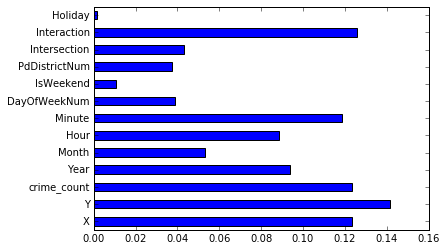

In [9]:
pd.Series(clf.feature_importances_, X.columns).plot(kind="barh")

In [10]:
X_predict = pd.read_csv("../../data/test.csv")
X_predict = DuplicateCrimeCounts().fit_transform(X_predict)
X_predict = BasicFeatures().fit_transform(X_predict)
X_predict = JustNumerics().fit_transform(X_predict)
X_predict.drop(["Id"], axis=1, inplace=True)

In [11]:
final_predictions = make_predictions(X_predict, clf)

In [12]:
%%time
# Export predictions to file to be submitted to Kaggle
make_Kaggle_file(final_predictions, labels.classes_, decimal_limit=5)

Finished writing file:  sf_crime_test_predictions_20160424-100641.csv
CPU times: user 50.8 s, sys: 548 ms, total: 51.3 s
Wall time: 51.4 s


# Grid search used to find appropriate hyperparameters

In [4]:
percent_of_data_to_use = .05

# Read in training data
X = pd.read_csv("../../data/train.csv")

# Do stateless transformations first
X = DuplicateCrimeCounts().fit_transform(X)
X = BasicFeatures().fit_transform(X)

# Shuffle the dataset
X = X.sample(frac=percent_of_data_to_use, random_state=42).reset_index(drop=True)
y = X.pop('Category')

# Convert y labels to integer representations
labels = LabelEncoder()
y = labels.fit_transform(y)

In [5]:
%%time

# This seed is required for each gridsearch to be identical
np.random.seed(1)

# Define the ML pipe
pipe = Pipeline([("BFE", BasicFeatures()), 
                 ("just_numerics", JustNumerics()), 
#                  ("PCA", PCATransform()), 
#                  ("LR_feature", ModelBasedFeatures(LogisticRegression(), feature_name="LR_feature", train_cv=2)),
#                  ("RF_feature", ModelBasedFeatures(model=RandomForestClassifier(), feature_name="RF_feature", train_cv=2)),
                 ("RF", RandomForestClassifier(n_jobs=1))])

PCA_factor = .6

params = {
          "BFE__date_features": sp_randint(0, 2),
          "BFE__DayOfWeek_features": sp_randint(0, 2),
          "BFE__PdDistrict_features": sp_randint(0, 2),
          "BFE__Address_features": sp_randint(0, 2),
          "BFE__Interaction_feature": sp_randint(0, 2),
#           "PCA__n_components": sp_uniform(PCA_factor, 1-PCA_factor),
#           "PCA__skip": sp_randint(0, 2),
#           "PCA__standard_scalar": sp_randint(0, 2),
#           "RF_feature__skip": sp_randint(0, 2),
#           "LR_feature__skip": sp_randint(0, 2),
          "RF__n_estimators": sp_randint(25, 200),
          "RF__max_depth": sp_randint(10, 100),
          "RF__min_samples_split": sp_randint(15, 65),
          "RF__min_samples_leaf": sp_randint(1, 70),
          "RF__max_leaf_nodes": sp_randint(2000, 7000),
          "RF__max_features": ["auto", .25, .5, .3]
         }

fit_params = {
#               "RF_feature__n_estimators": sp_randint(5, 10),
#               "RF_feature__max_depth": sp_randint(5, 10),
#               "LR_feature__C": sp_expon(4, 20)
             }

gridsearch = RandomizedSearchCV(pipe, params, fit_params=None, n_iter=50, scoring="log_loss", cv=2, n_jobs=-1)
gridsearch.fit(X, y)

CPU times: user 15.4 s, sys: 384 ms, total: 15.8 s
Wall time: 45.1 s


Best score: -2.31994352368 




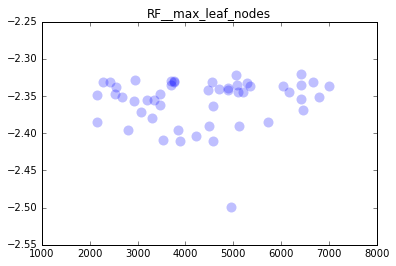

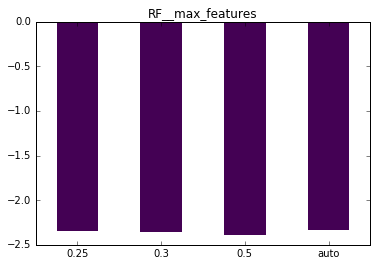

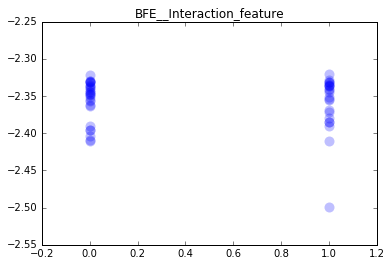

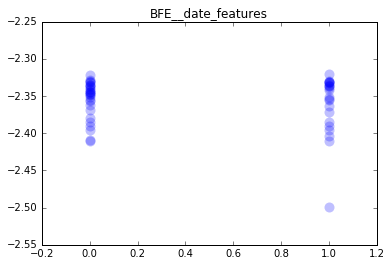

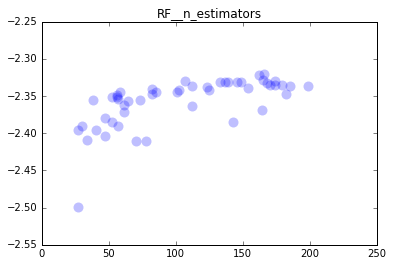

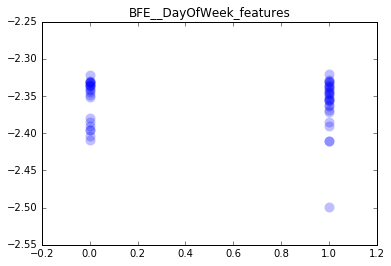

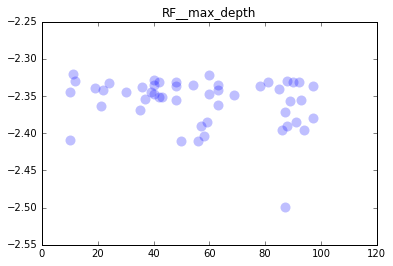

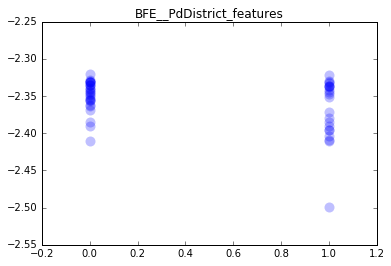

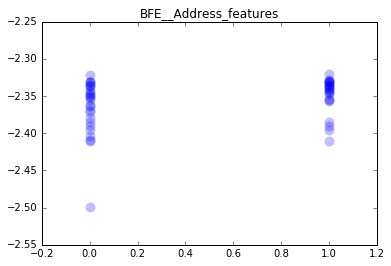

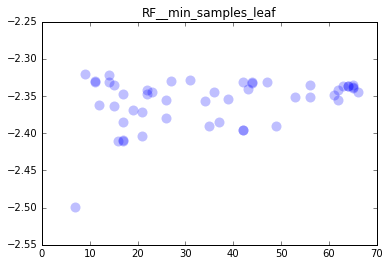

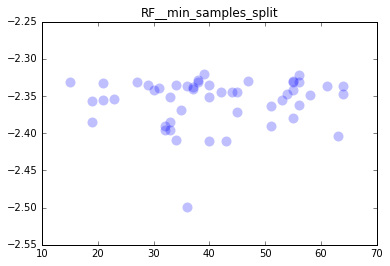

In [6]:
print("Best score:", gridsearch.best_score_, "\n")
print("")

gridsearch_parameter_results(gridsearch)